In [1]:
# !pip install pinecone-client
# !pip install boto3

In [2]:
# !pip install moviepy
# !pip install pandas

In [3]:
# !cd ImageBind; pip install .

In [4]:
# !pip install opencv-python
# !pip install scenedetect

## Sound Search

In [700]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math
import os

from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from imagebind.data import transform_and_sample_video_tensor, load_and_transform_audio_data_tensors
from imagebind import data as imagebind_data

from moviepy.editor import ImageSequenceClip, VideoFileClip

from IPython.display import display, Audio

from scenedetect import detect, AdaptiveDetector

from pinecone import Pinecone

from utils.datasets import StronglyLabelledDataset

In [7]:
# Pinecone connection
pc = Pinecone(api_key=os.environ.get('PINECONE_API_KEY'))

index = pc.Index(os.environ.get('INDEX_NAME'))

In [683]:
# Ontology audioset dataset
ontology = pd.read_json('data/ontology.json')[['id','name', 'description']]
augmented = pd.read_csv('data/augmented_labels_cleaned.csv', index_col=0)

ontology = pd.merge(ontology, augmented.drop(columns=['description']), how='left', on='name')

ontology

id                           name  \
0    /m/0dgw9r                   Human sounds   
1     /m/09l8g                    Human voice   
2     /m/09x0r                         Speech   
3    /m/05zppz      Male speech, man speaking   
4     /m/02zsn  Female speech, woman speaking   
..         ...                            ...   
627  /m/025l19                      Recording   
628  /m/07hvw1                Field recording   
629  /m/0174nj              Gramophone record   
630   /m/01www                   Compact disc   
631   /m/04zc0                            MP3   

                                           description MajorityType  \
0    Sounds produced by the human body through the ...          SFX   
1    The human voice consists of sound made by a hu...          SFX   
2    Speech is the vocalized form of human communic...          SFX   
3               Speech uttered by an adult male human.          SFX   
4             Speech uttered by an adult female human.          SFX   
..                                                 ...          ...   
627  A sound that appears to come from a recording ...          SFX   
628  A sound that appears to have been recorded in ...          AMB   
629  A sound which appears to come from a gramophon...          SFX   
630  A sound which appears to come from a digital a...          SFX   
631  A sound which appears to come from a compresse...          SFX   

              Object  Exclude  
0              human        0  
1              human        1  
2              human        1  
3              human        1  
4              human        1  
..               ...      ...  
627  recorder/player        0  
628              NaN        0  
629       gramophone        0  
630     compact disc        0  
631     digital file        0  

[632 rows x 6 columns]

In [16]:
def play_video(video, video_fps):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    
    # Adjust the normalization of the video to match 0-255 scale
    video = video * std + mean  # Denormalize
    video = video.clamp(0, 1)  # Clamp to the range [0, 1]
    video = video.permute(0, 2, 3, 1)  # Change to [frames, height, width, channels]
    
    # Scale to 0-255 and convert to uint8
    video_tensor = (video * 255).numpy().astype(np.uint8)

    # Writing to a video file using OpenCV
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output_video.mp4', fourcc, video_fps, (224, 224))
    for i in range(video_tensor.shape[0]):
        out.write(video_tensor[i])
    out.release()

    # Load your video file
    clip = VideoFileClip('output_video.mp4')
    clip.fps = video_fps

    print(clip.fps)
    clip.write_videofile("test_output.mp4", fps=clip.fps)
    
    # Display the video
    display(clip.ipython_display(width=480, autoplay=1, loop=1, maxduration=120, fps=video_fps))

**Load Video**

In [17]:
dataset = StronglyLabelledDataset()

In [979]:
video_id = np.random.randint(10000)
print(video_id)
video, audio, labels_df, info = dataset[video_id]

video_fps = info['video_fps']
audio_fps = info['audio_fps']

print(video.shape)
print(info)

8275
torch.Size([250, 3, 224, 224])
{'video_fps': 25.0, 'audio_fps': 44100}


In [978]:
#To load from local
from torchvision.io import read_video
from torchvision.transforms import Compose, Lambda
import torchvision.transforms.functional as FV

transforms = Compose([
            Lambda(lambda video: [FV.to_pil_image(frame) for frame in video]),  # Convert each frame to PIL Image
            Lambda(lambda frames: [FV.resize(frame, size=(224, 224)) for frame in frames]),  # Resize each frame
            Lambda(lambda frames: torch.stack([FV.to_tensor(frame) for frame in frames])),  # Convert frames to tensors and stack
            Lambda(lambda frames: torch.stack([FV.normalize(frame, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) for frame in frames]))  # Normalize and stack
        ])

video, audio, info = read_video('data/output_video (10).mp4')
video = video.permute(0, 3, 1, 2)
print(video.shape)

video = transforms(video)
print(video.shape)
print(info)

torch.Size([301, 3, 224, 224])
torch.Size([301, 3, 224, 224])
{'video_fps': 29.0}


In [488]:
# video = video.permute(0, 3, 1, 2)

In [5]:
play_video(video, int(info['video_fps']))

**Scene Splitting**

In [981]:
video_local_path = "output_video.mp4"

scenes = detect(video_local_path, AdaptiveDetector())

In [982]:
scenes

[(00:00:00.000 [frame=0, fps=25.000], 00:00:03.600 [frame=90, fps=25.000]),
 (00:00:03.600 [frame=90, fps=25.000], 00:00:08.600 [frame=215, fps=25.000]),
 (00:00:08.600 [frame=215, fps=25.000], 00:00:10.000 [frame=250, fps=25.000])]

**Embed Video**

In [6]:
# This must be done by scene too.
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()

model.to(device)

In [983]:
labels_df = pd.merge(labels_df, ontology, how='left', left_on='label', right_on='id')

In [984]:
labels_df

segment_id  start_time_seconds  end_time_seconds       label  \
0  D_9ckXR1Pdo_110000               0.000             4.354   /m/02l6bg   
1  D_9ckXR1Pdo_110000               3.236            10.000  /t/dd00092   
2  D_9ckXR1Pdo_110000               4.512             6.213    /m/09l8g   
3  D_9ckXR1Pdo_110000               5.512             5.630  /t/dd00099   
4  D_9ckXR1Pdo_110000               6.063             6.110  /m/07qjznt   
5  D_9ckXR1Pdo_110000               6.252             6.299  /t/dd00099   
6  D_9ckXR1Pdo_110000               6.756             6.811  /t/dd00099   
7  D_9ckXR1Pdo_110000               7.197             7.283  /t/dd00099   
8  D_9ckXR1Pdo_110000               7.575            10.000   /m/02l6bg   

           id                     name  \
0   /m/02l6bg      Propeller, airscrew   
1  /t/dd00092  Wind noise (microphone)   
2    /m/09l8g              Human voice   
3  /t/dd00099    Generic impact sounds   
4  /m/07qjznt                     Tick   
5  /t/dd00099    Generic impact sounds   
6  /t/dd00099    Generic impact sounds   
7  /t/dd00099    Generic impact sounds   
8   /m/02l6bg      Propeller, airscrew   

                                         description MajorityType  \
0  The sound of an aircraft propulsion system tha...          SFX   
1  The noise produced when a strong air current p...          SFX   
2  The human voice consists of sound made by a hu...          SFX   
3  Sounds of impacts or collisions preferentially...          SFX   
4                          A metallic tapping sound.          SFX   
5  Sounds of impacts or collisions preferentially...          SFX   
6  Sounds of impacts or collisions preferentially...          SFX   
7  Sounds of impacts or collisions preferentially...          SFX   
8  The sound of an aircraft propulsion system tha...          SFX   

            Object  Exclude                                          Full Text  
0         aircraft        0  Propeller, airscrew: The sound of an aircraft ...  
1       microphone        0  Wind noise (microphone): The noise produced wh...  
2            human        1  Human voice: The human voice consists of sound...  
3              NaN        0  Generic impact sounds: Sounds of impacts or co...  
4  metallic object        0    Tick: A metallic tapping sound. Object: Unknown  
5              NaN        0  Generic impact sounds: Sounds of impacts or co...  
6              NaN        0  Generic impact sounds: Sounds of impacts or co...  
7              NaN        0  Generic impact sounds: Sounds of impacts or co...  
8         aircraft        0  Propeller, airscrew: The sound of an aircraft ...

In [183]:
video = video.permute(0, 2, 3, 1)

In [751]:
video.shape

torch.Size([301, 224, 224, 3])

In [752]:
scaled_video = transform_and_sample_video_tensor(video, device, clips_per_video=1)

print(f"Video Shape: {scaled_video.shape}")

inputs = {
    ModalityType.VISION: scaled_video,
}

with torch.no_grad():
    outputs = model(inputs)

print(f"Output Shape: {outputs['vision'].shape}")
video_embeddings = outputs['vision']

Video Shape: torch.Size([1, 301, 3, 224, 224])
Output Shape: torch.Size([1, 1024])


**Embed Text**

In [722]:
ontology

id                           name  \
0    /m/0dgw9r                   Human sounds   
1     /m/09l8g                    Human voice   
2     /m/09x0r                         Speech   
3    /m/05zppz      Male speech, man speaking   
4     /m/02zsn  Female speech, woman speaking   
..         ...                            ...   
627  /m/025l19                      Recording   
628  /m/07hvw1                Field recording   
629  /m/0174nj              Gramophone record   
630   /m/01www                   Compact disc   
631   /m/04zc0                            MP3   

                                           description MajorityType  \
0    Sounds produced by the human body through the ...          SFX   
1    The human voice consists of sound made by a hu...          SFX   
2    Speech is the vocalized form of human communic...          SFX   
3               Speech uttered by an adult male human.          SFX   
4             Speech uttered by an adult female human.          SFX   
..                                                 ...          ...   
627  A sound that appears to come from a recording ...          SFX   
628  A sound that appears to have been recorded in ...          AMB   
629  A sound which appears to come from a gramophon...          SFX   
630  A sound which appears to come from a digital a...          SFX   
631  A sound which appears to come from a compresse...          SFX   

              Object  Exclude  \
0              human        0   
1              human        1   
2              human        1   
3              human        1   
4              human        1   
..               ...      ...   
627  recorder/player        0   
628              NaN        0   
629       gramophone        0   
630     compact disc        0   
631     digital file        0   

                                             Full Text  
0    Human sounds: Sounds produced by the human bod...  
1    Human voice: The human voice consists of sound...  
2    Speech: Speech is the vocalized form of human ...  
3    Male speech, man speaking: Speech uttered by a...  
4    Female speech, woman speaking: Speech uttered ...  
..                                                 ...  
627  Recording: A sound that appears to come from a...  
628                                                NaN  
629  Gramophone record: A sound which appears to co...  
630  Compact disc: A sound which appears to come fr...  
631  MP3: A sound which appears to come from a comp...  

[632 rows x 7 columns]

In [734]:
labels_list = ontology.name.unique()
# labels_list = ontology.name.unique()
object = np.where(isinstance(ontology['Object'], str), ontology['Object'], 'Unknown')
ontology['Full Text'] = ontology['name'] + ': ' + ontology['description'] + ' Object: ' + object
labels_list = ontology['Full Text'].unique()

inputs = {
    ModalityType.TEXT: imagebind_data.load_and_transform_text(labels_list, device)
}

with torch.no_grad():
    output = model(inputs)

text_embeddings = output[ModalityType.TEXT]

In [735]:
text_embeddings.shape

torch.Size([632, 1024])

**Embed Audio**

In [161]:
# Already done in Pinecone

**Video-Text-Audio**

Video -> Text

In [753]:
ontology

id                           name  \
0    /m/0dgw9r                   Human sounds   
1     /m/09l8g                    Human voice   
2     /m/09x0r                         Speech   
3    /m/05zppz      Male speech, man speaking   
4     /m/02zsn  Female speech, woman speaking   
..         ...                            ...   
627  /m/025l19                      Recording   
628  /m/07hvw1                Field recording   
629  /m/0174nj              Gramophone record   
630   /m/01www                   Compact disc   
631   /m/04zc0                            MP3   

                                           description MajorityType  \
0    Sounds produced by the human body through the ...          SFX   
1    The human voice consists of sound made by a hu...          SFX   
2    Speech is the vocalized form of human communic...          SFX   
3               Speech uttered by an adult male human.          SFX   
4             Speech uttered by an adult female human.          SFX   
..                                                 ...          ...   
627  A sound that appears to come from a recording ...          SFX   
628  A sound that appears to have been recorded in ...          AMB   
629  A sound which appears to come from a gramophon...          SFX   
630  A sound which appears to come from a digital a...          SFX   
631  A sound which appears to come from a compresse...          SFX   

              Object  Exclude  \
0              human        0   
1              human        1   
2              human        1   
3              human        1   
4              human        1   
..               ...      ...   
627  recorder/player        0   
628              NaN        0   
629       gramophone        0   
630     compact disc        0   
631     digital file        0   

                                             Full Text  
0    Human sounds: Sounds produced by the human bod...  
1    Human voice: The human voice consists of sound...  
2    Speech: Speech is the vocalized form of human ...  
3    Male speech, man speaking: Speech uttered by a...  
4    Female speech, woman speaking: Speech uttered ...  
..                                                 ...  
627  Recording: A sound that appears to come from a...  
628  Field recording: A sound that appears to have ...  
629  Gramophone record: A sound which appears to co...  
630  Compact disc: A sound which appears to come fr...  
631  MP3: A sound which appears to come from a comp...  

[632 rows x 7 columns]

In [755]:
vision_text_similarity = torch.softmax(video_embeddings @ text_embeddings.T, dim=-1)

match_ont_df = ontology.copy()
match_ont_df['similarity'] = vision_text_similarity.cpu().numpy()[0]
# match_ont_df = match_ont_df[match_ont_df['MajorityType'] == 'SFX']
match_ont_df.sort_values('similarity', ascending=False).head(10)

id                           name  \
295    /m/0155w                          Blues   
269   /m/06j64v           Middle Eastern music   
407  /t/dd00065  Light engine (high frequency)   
340  /t/dd00037                    Scary music   
250   /m/04j_h4                    Grime music   
605  /t/dd00128      Outside, urban or manmade   
623    /m/07c52                     Television   
336  /t/dd00033                      Sad music   
604  /t/dd00127           Inside, public space   
511    /m/039jq                          Glass   

                                           description MajorityType  \
295  A genre and musical form developed by African ...          MUS   
269  Music originating from the vast region from Mo...          MUS   
407  The sound of a small engine such as a toy car,...          SFX   
340     Music that evokes or conveys feelings of fear.          MUS   
250  A genre of music that emerged in East London i...          MUS   
605  Sounds that appear to have been recorded outdo...          AMB   
623  A sound that appears to have been produced by ...          SFX   
336  Music that evokes or conveys feelings of sadness.          MUS   
604  Sounds that appear to have been recorded in a ...          AMB   
511  Sounds associated with the non-crystalline amo...          SFX   

             Object  Exclude  \
295             NaN        0   
269             NaN        0   
407           moped        0   
340      mp3 player        0   
250             NaN        0   
605             NaN        0   
623  television set        0   
336      Microphone        0   
604             NaN        0   
511           glass        0   

                                             Full Text    similarity  
295  Blues: A genre and musical form developed by A...  4.999920e-01  
269  Middle Eastern music: Music originating from t...  4.999920e-01  
407  Light engine (high frequency): The sound of a ...  3.032117e-06  
340  Scary music: Music that evokes or conveys feel...  9.128026e-07  
250  Grime music: A genre of music that emerged in ...  7.577177e-07  
605  Outside, urban or manmade: Sounds that appear ...  6.924251e-07  
623  Television: A sound that appears to have been ...  4.281231e-07  
336  Sad music: Music that evokes or conveys feelin...  4.163107e-07  
604  Inside, public space: Sounds that appear to ha...  3.867343e-07  
511  Glass: Sounds associated with the non-crystall...  3.757025e-07

In [173]:
first_match, similarity = match_ont_df.sort_values('similarity', ascending=False).iloc[0]['id'], match_ont_df.sort_values('similarity', ascending=False).iloc[0]['similarity']

In [174]:
first_match

'/m/07rcgpl'

Text -> Audio

In [175]:
def query_with_metadata_filter(query_vector, metadata_filter, top_k=5):
    results = index.query(
        vector=video_embeddings.cpu().tolist(),  ## NOTE: pinecone expects list for serialization
        top_k=3,
        include_values=False,  # This returns embeddings of result
        include_metadata=True,
        filter = metadata_filter
    )
    return results

metadata_filter = {"type": "SFX",
                   "label_id": first_match}

search_result = query_with_metadata_filter(video_embeddings.cpu().tolist(), metadata_filter)

In [176]:
search_result

{'matches': [], 'namespace': '', 'usage': {'read_units': 6}}

In [121]:
folder_names = dataset.get_folder_names('train_strong/')

In [133]:
match_id = 0

mtdf = pd.DataFrame(folder_names)
mtdf.columns = ['video_id']

video_id = search_result['matches'][match_id]['id'].split('_')[0] + '_' + search_result['matches'][match_id]['id'].split('_')[1]
start_second = search_result['matches'][match_id]['metadata']['start_time']
end_second = search_result['matches'][match_id]['metadata']['end_time']

index_n = mtdf[mtdf['video_id'] == video_id].index[0]

In [124]:
_, audio, _, info = dataset[index_n]

In [134]:
audio_np = audio.numpy()
num_channels, num_samples = audio_np.shape
sample_rate = info['audio_fps']

# Slice the audio
start_index = int(start_second * sample_rate)
end_index = int(end_second * sample_rate)
audio_segment = audio_np[:, start_index:end_index]

Audio(audio_np, rate=sample_rate)

**Video-Audio**

In [126]:
def query_with_metadata_filter(query_vector, metadata_filter, top_k=5):
    results = index.query(
        vector=video_embeddings.cpu().tolist(),  ## NOTE: pinecone expects list for serialization
        top_k=5,
        include_values=False,  # This returns embeddings of result
        include_metadata=True,
        filter = metadata_filter
    )
    return results

metadata_filter = {"type": "SFX"}

search_result = query_with_metadata_filter(video_embeddings.cpu().tolist(), metadata_filter)

In [127]:
ids = []
sim = []
start_time = []
end_time = []
label = []
type = []

for match in search_result['matches']:
    ids.append(match['id'])
    sim.append(match['score'])
    start_time.append(match['metadata']['start_time'])
    end_time.append(match['metadata']['end_time'])
    label.append(match['metadata']['label_id'])
    type.append(match['metadata']['type'])

data_dict = {
    'id': ids,
    'similarity': sim, 
    'start_time': start_time,
    'end_time': end_time,
    'label': label,
    'type': type
}

In [128]:
matches_df = pd.DataFrame(data_dict)
matches_df = pd.merge(matches_df, ontology[['id', 'name', 'description']], how='left', left_on='label', right_on='id')
matches_df

id_x  similarity  start_time  end_time       label type  \
0   54m4FWVdwkI_310000_2    7.146260       0.322     0.647  /t/dd00092  SFX   
1  AdfTS1LDw2o_120000_13    6.962275       4.609     5.615   /m/05tny_  SFX   
2    E3D_z0aoUEg_30000_2    6.951942       4.492     8.219    /m/09ld4  SFX   
3   8eE1Gksyma0_300000_0    6.801106       0.000     3.575    /m/0ngt1  SFX   
4   AdfTS1LDw2o_120000_7    6.769963       1.564     2.291   /m/05zppz  SFX   

         id_y                       name  \
0  /t/dd00092    Wind noise (microphone)   
1   /m/05tny_                       Bark   
2    /m/09ld4                       Frog   
3    /m/0ngt1                    Thunder   
4   /m/05zppz  Male speech, man speaking   

                                         description  
0  The noise produced when a strong air current p...  
1  Principal communication sound produced by dogs...  
2  Sounds associated with the short-bodied, taill...  
3  The sound caused by lightning. Depending on th...  
4             Speech uttered by an adult male human.

In [129]:
mtdf = pd.DataFrame(folder_names)
mtdf.columns = ['video_id']

In [130]:
match_n = 0

video_id = matches_df.iloc[match_n]['id_x'].split('_')[0] + '_' + matches_df.iloc[match_n]['id_x'].split('_')[1]

index_n = mtdf[mtdf['video_id'] == video_id].index[0]

In [131]:
_, audio, _, info = dataset[index_n]
audio_np = audio.numpy()
num_channels, num_samples = audio_np.shape
sample_rate = info['audio_fps']

# Slice the audio
start_index = int(start_second * sample_rate)
end_index = int(end_second * sample_rate)
audio_segment = audio_np[:, start_index:end_index]

Audio(audio_np, rate=sample_rate)

# AutoSync

**Embed video chunks**

In [816]:
#video = video.permute(0, 1, 3, 2)
video.shape

torch.Size([301, 3, 224, 224])

In [985]:
## Video-text-audio
interval_seconds = 0.2
video_fps = info['video_fps']

seconds = video.shape[0] / video_fps
number_of_segments = int(seconds / interval_seconds)

# number_of_segments = video.shape[0]

video = video.permute(0, 2, 3, 1)
scaled_video = transform_and_sample_video_tensor(video, device, clips_per_video = number_of_segments)

inputs = {
    ModalityType.VISION: scaled_video,
}

with torch.no_grad():
    outputs = model(inputs)
    
video_embeddings = outputs['vision']

In [986]:
print(f'Video Embeddings shape: {video_embeddings.shape}')
print(f'Text Embeddings shape: {text_embeddings.shape}')

Video Embeddings shape: torch.Size([50, 1024])
Text Embeddings shape: torch.Size([632, 1024])


In [987]:
product = video_embeddings @ text_embeddings.T

softmax_output = F.softmax(product, dim=1)

softmax_output.shape

torch.Size([50, 632])

In [988]:
TYPE = 'SFX'

dataframes = []
for segment in range(softmax_output.shape[0]):
    match_ont_df = ontology.copy()
    
    # Extract similarities
    # segment_similarity = softmax_output[segment]
    # match_ont_df['similarity'] = segment_similarity.cpu().numpy()

    # Compute Softmax at MajorityType granularity
    match_ont_df['product'] = product[segment].cpu().numpy()
    match_ont_df = match_ont_df[match_ont_df['MajorityType'] == TYPE]
    match_ont_df['similarity'] = F.softmax(torch.tensor(match_ont_df['product'].tolist()))

    match_ont_df = match_ont_df.sort_values('similarity', ascending=False)
    dataframes.append(match_ont_df)

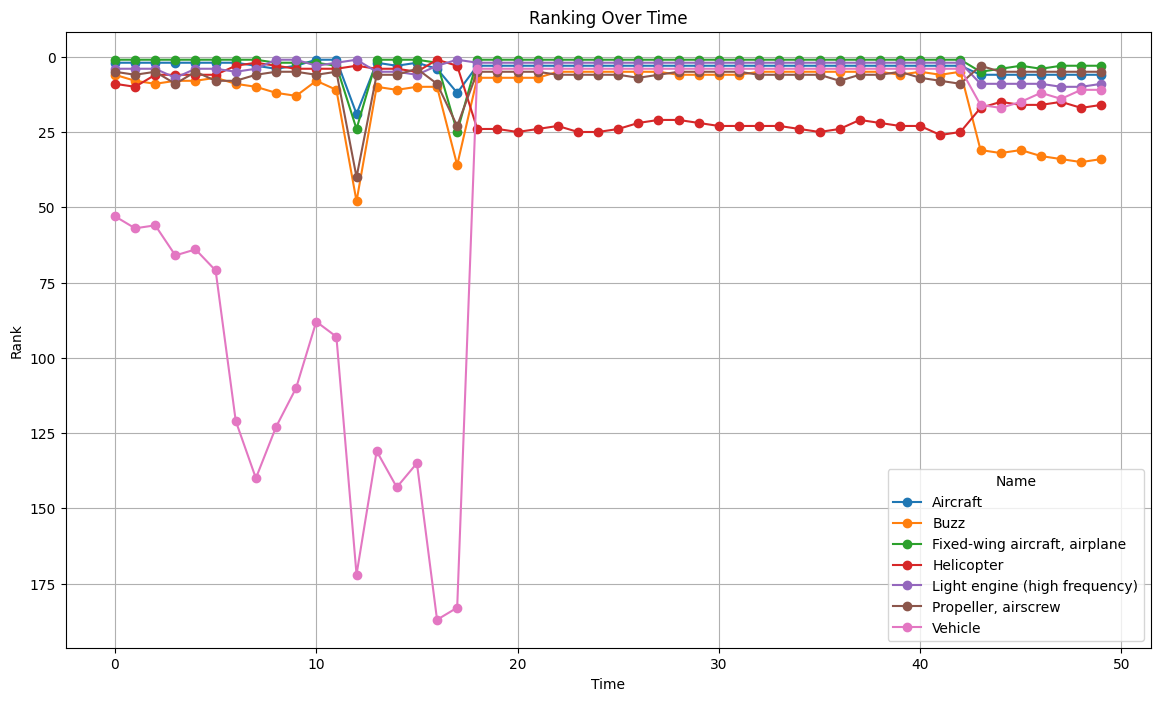

In [989]:
all_data = pd.concat([df.assign(Time=i) for i, df in enumerate(dataframes)], ignore_index=True)

# Calculate rankings
all_data['Rank'] = all_data.groupby('Time')['similarity'].rank(ascending=False)

top_names = all_data[all_data['Rank'] <= 7]['name'].value_counts().nlargest(7).index.tolist()
filtered_data = all_data[all_data['name'].isin(top_names)]
pivot_data = filtered_data.pivot(index='Time', columns='name', values='Rank')

# Plot
plt.figure(figsize=(14, 8))
for column in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[column], label=column, marker='o')
plt.gca().invert_yaxis() 
plt.title('Ranking Over Time')
plt.xlabel('Time')
plt.ylabel('Rank')
plt.legend(title='Name')
plt.grid(True)
plt.show()

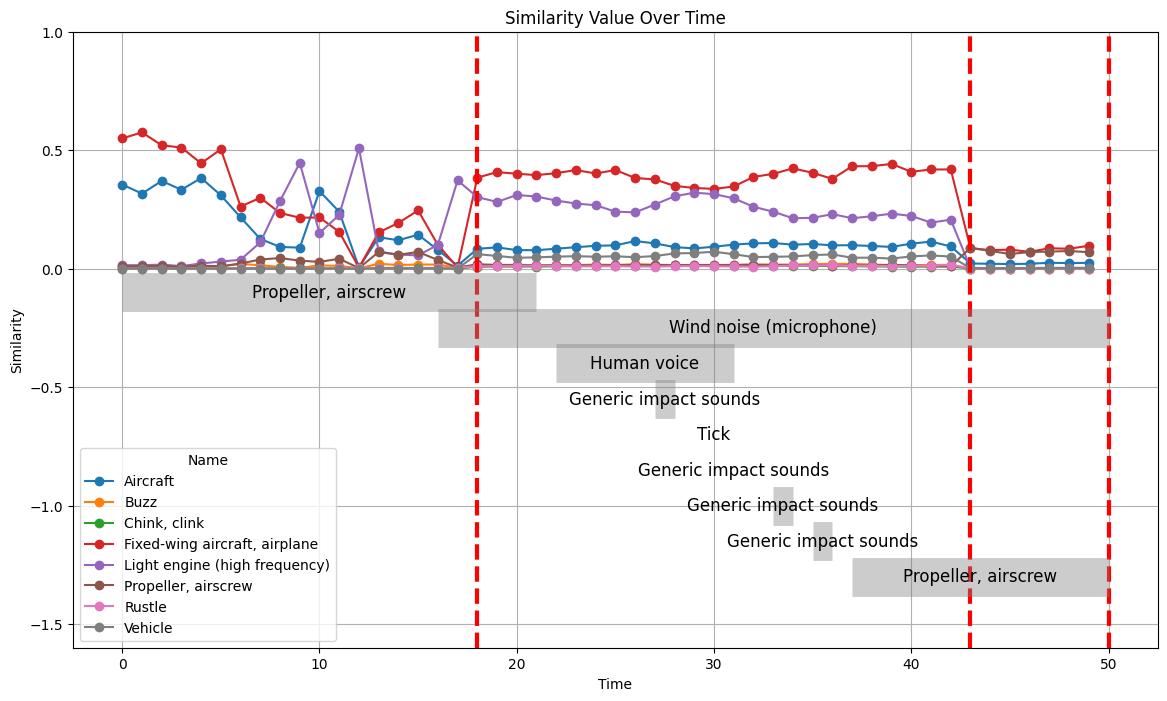

In [990]:
# Concatenate all dataframes with a new 'Time' column
all_data = pd.concat([df.assign(Time=i) for i, df in enumerate(dataframes)], ignore_index=True)

top_names = all_data.groupby('Time').apply(lambda x: x.nlargest(8, 'similarity'))['name'].value_counts().nlargest(8).index
filtered_data = all_data[all_data['name'].isin(top_names)]
pivot_data = filtered_data.pivot(index='Time', columns='name', values='similarity')
    
# Plot
plt.figure(figsize=(14, 8))
for column in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[column], label=column, marker='o')

# Plot scene
ratio = int(video.shape[0] / len(dataframes))
for scene_n, scene in enumerate(scenes):
    end_frame_scene = scene[1].frame_num
    end_frame_new = end_frame_scene / ratio
    plt.axvline(x=end_frame_new, color='red', linestyle='--', linewidth=3)
    #plt.text(end_frame_new - 5, plt.ylim()[1]-0.05, f'Scene {scene_n + 1}', verticalalignment='top', horizontalalignment='left', fontsize=12, color='red')

bar_y_position = -0.1
bar_height = 0.2
y_pos_increment = -0.15  

for i, row in labels_df.iterrows():
    start_time = row['start_time_seconds']
    start_time = int(start_time * video_fps / ratio)
    
    end_time = row['end_time_seconds']
    end_time = int(end_time * video_fps / ratio)
    label = row['name']
    
    # Adjust y position for each segment
    current_y_pos = bar_y_position + (i * y_pos_increment)

    plt.hlines(current_y_pos, start_time, end_time, colors='grey', lw=28, alpha=0.4) 

    plt.text((start_time + end_time) / 2, current_y_pos, label, ha='center', va='center', fontsize=12, color='black')

plt.ylim(top=1, bottom=current_y_pos + 2*y_pos_increment) 
plt.title('Similarity Value Over Time')
plt.xlabel('Time')
plt.ylabel('Similarity')
plt.legend(title='Name')
plt.grid(True)
plt.show()

### **Synching Algorithm**

In [991]:
### HYPERPARAMETERS
alpha = 0.1 ## Similarity threshold
gamma = 0.3 ## Movement threshold

# ALGORITHM
intervals = {}
for col in pivot_data.columns:
    df = pivot_data[[col]]
    
    df['valid'] = df[col] > alpha
    
    # Step 2: Identify consecutive groups
    df['group'] = (df['valid'] != df['valid'].shift()).cumsum()
    
    # Get only valid groups
    valid_groups = df[df['valid']].groupby('group')
    
    # Function to find the largest valid subinterval that includes at least two values
    def find_largest_valid_subinterval(group):
        best_interval = None
        best_length = 0
        
        # Check every possible subinterval with at least 2 values
        for start in range(len(group)):
            for end in range(start + 2, len(group) + 1):  # start from start+2 to ensure at least two values
                sub_group = group.iloc[start:end]
                avg = sub_group[col].mean()
                lower_bound = avg * (1 - gamma)
                upper_bound = avg * (1 + gamma)
                if sub_group[col].between(lower_bound, upper_bound).all():
                    if (end - start) > best_length:
                        best_length = end - start
                        best_interval = (sub_group.index.min(), sub_group.index.max())
        
        return best_interval
    
    
    #intervals = []
    for name, group in valid_groups:
        interval = find_largest_valid_subinterval(group)
        if interval:
            try:
                intervals[col].append(interval)
            except KeyError:
                intervals[col] = []
                intervals[col].append(interval)

In [992]:
intervals

{'Aircraft': [(0, 5), (10, 11), (13, 15), (26, 27), (31, 35), (40, 41)],
 'Fixed-wing aircraft, airplane': [(0, 5), (13, 15), (18, 42)],
 'Light engine (high frequency)': [(8, 9), (18, 42)]}

In [993]:
synched_df = pd.DataFrame({'start_frame':[], 'end_frame':[], 'name':[]})
i=0
for label in intervals:
    print(label)
    for sync in intervals[label]:
        synched_df.loc[i] = [sync[0], sync[1], label]
        i+=1

synched_df

Aircraft
Fixed-wing aircraft, airplane
Light engine (high frequency)


start_frame  end_frame                           name
0             0          5                       Aircraft
1            10         11                       Aircraft
2            13         15                       Aircraft
3            26         27                       Aircraft
4            31         35                       Aircraft
5            40         41                       Aircraft
6             0          5  Fixed-wing aircraft, airplane
7            13         15  Fixed-wing aircraft, airplane
8            18         42  Fixed-wing aircraft, airplane
9             8          9  Light engine (high frequency)
10           18         42  Light engine (high frequency)

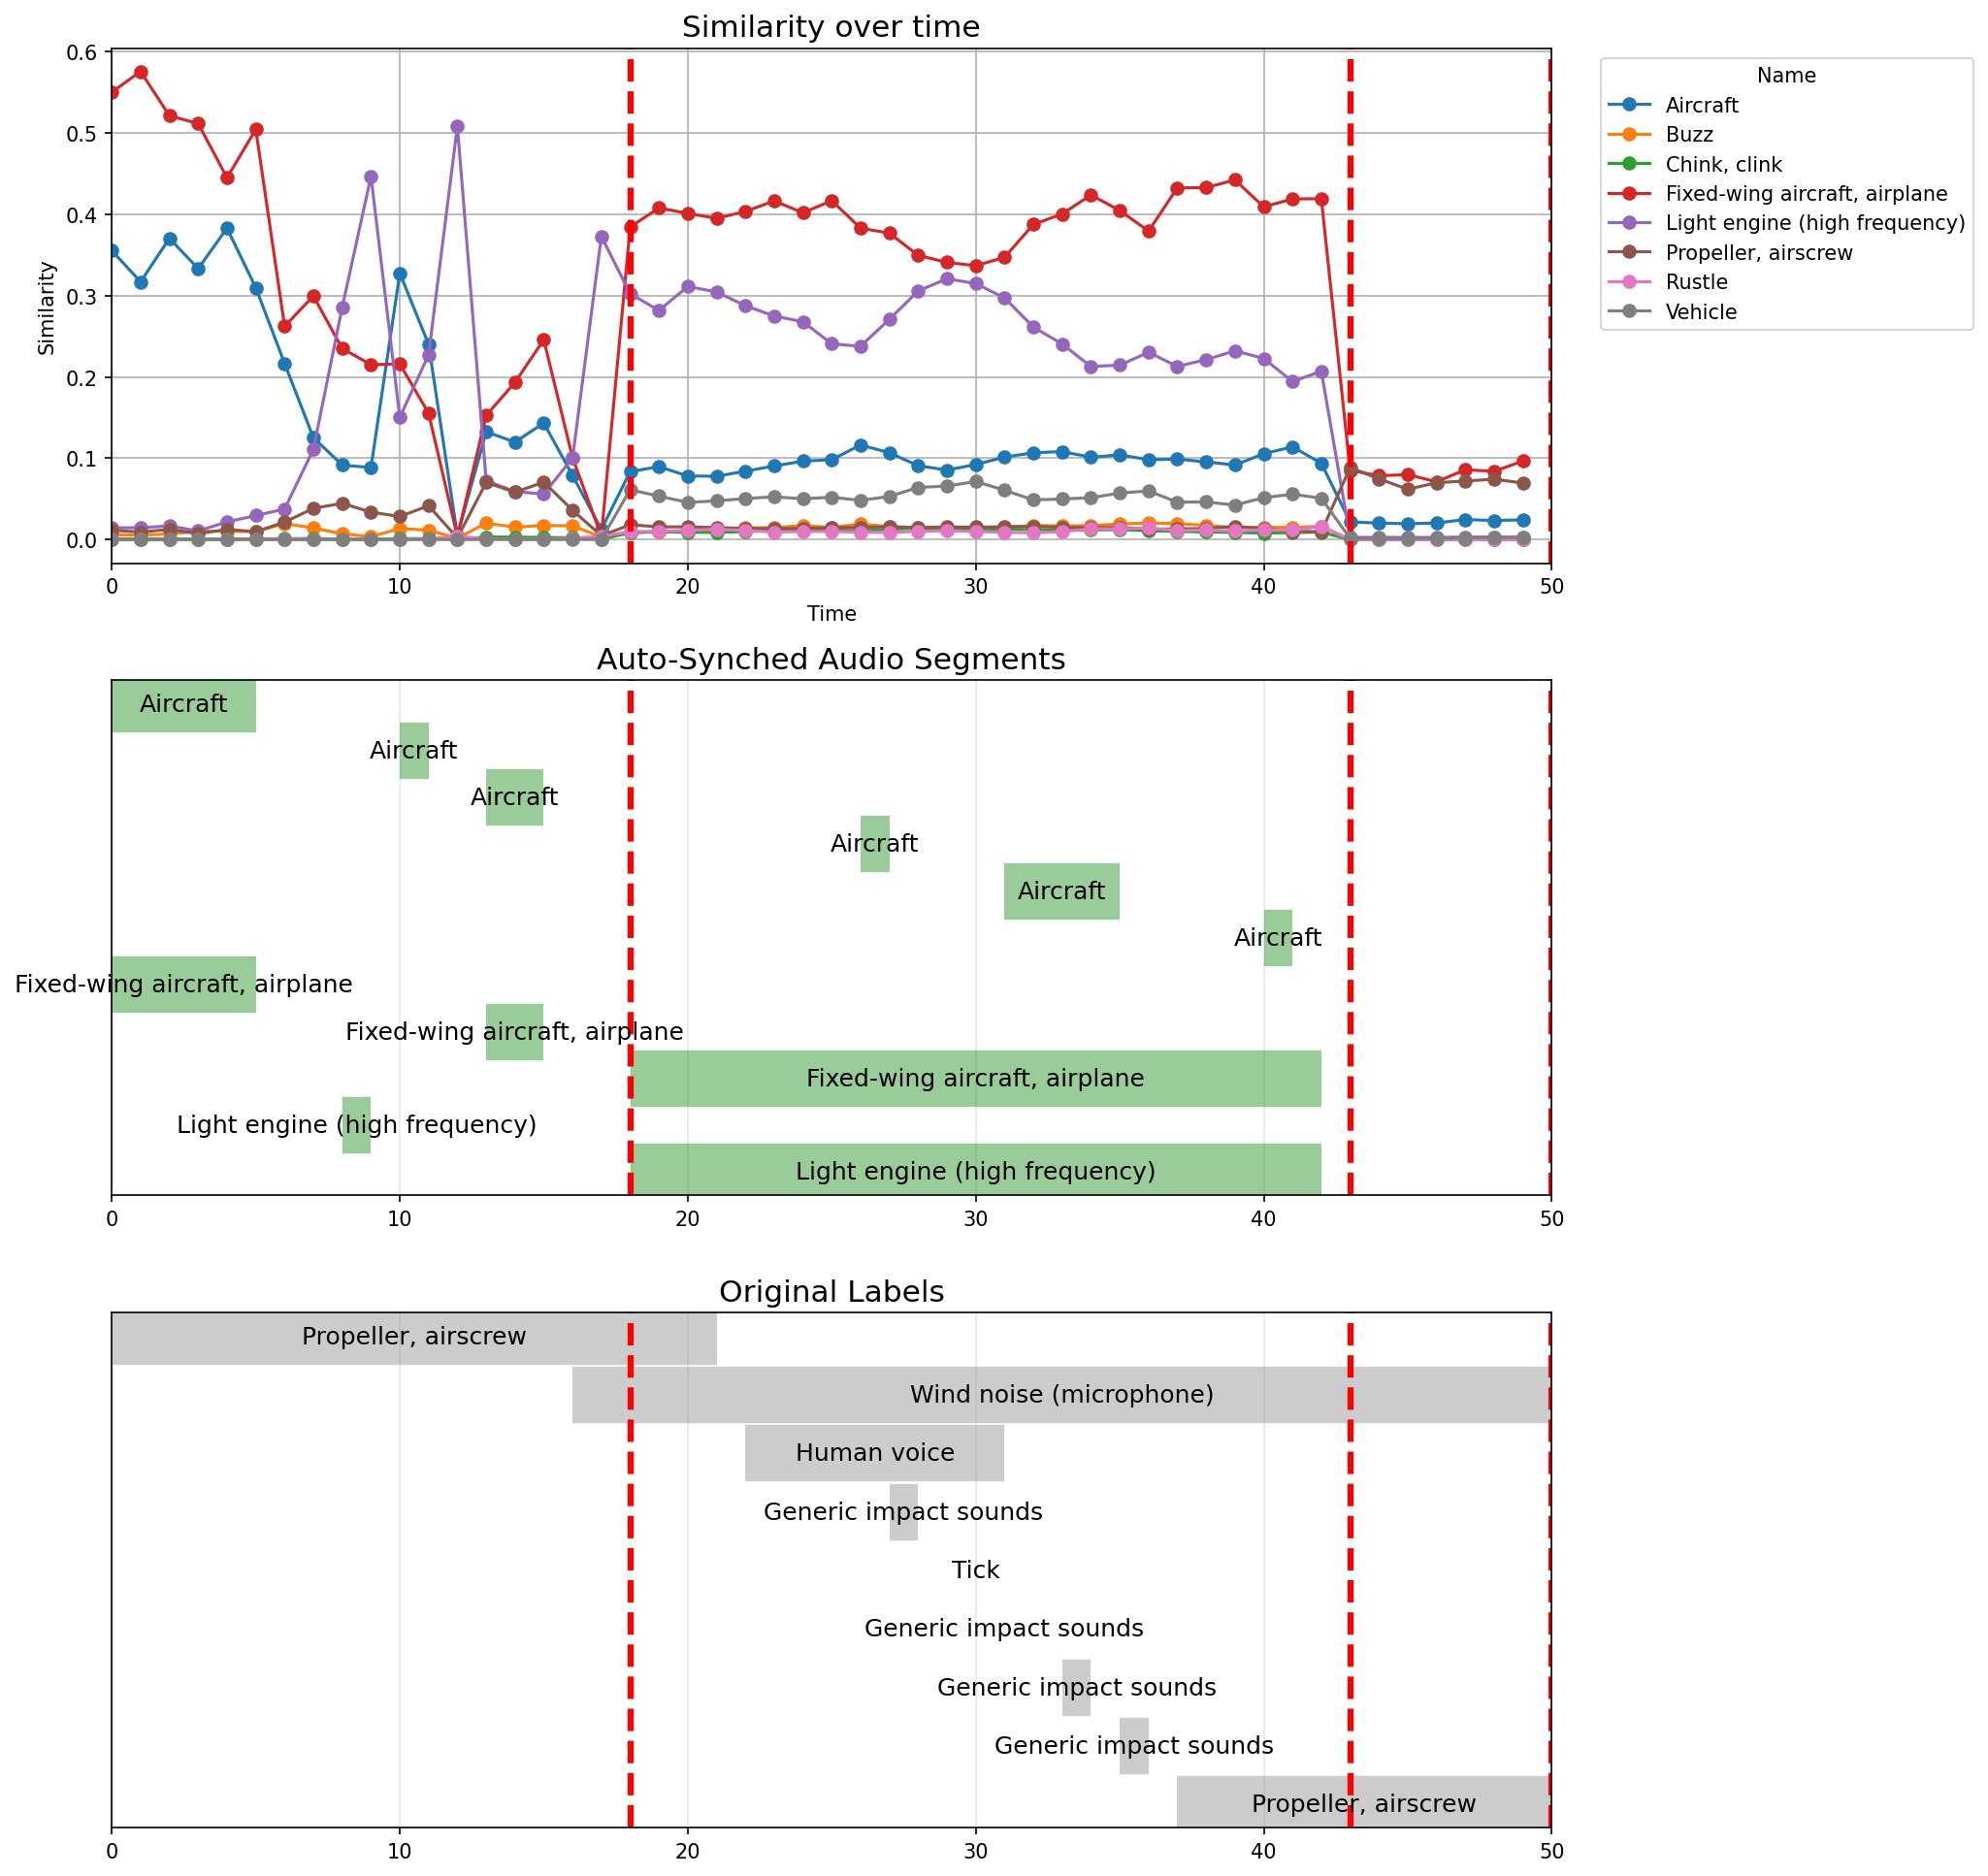

In [1005]:
# Concatenate all dataframes with a new 'Time' column
all_data = pd.concat([df.assign(Time=i) for i, df in enumerate(dataframes)], ignore_index=True)

top_names = all_data.groupby('Time').apply(lambda x: x.nlargest(8, 'similarity'))['name'].value_counts().nlargest(8).index
filtered_data = all_data[all_data['name'].isin(top_names)]
pivot_data = filtered_data.pivot(index='Time', columns='name', values='similarity')

x_max = len(pivot_data)
x_min = 0

# Plot
fig, ax = plt.subplots(3, 1, figsize=(14, 13), dpi=150)
for column in pivot_data.columns:
    ax[0].plot(pivot_data.index, pivot_data[column], label=column, marker='o')

# Plot scene
ratio = int(video.shape[0] / len(dataframes))
for scene_n, scene in enumerate(scenes):
    end_frame_scene = scene[1].frame_num
    end_frame_new = end_frame_scene / ratio
    ax[0].axvline(x=end_frame_new, color='red', linestyle='--', linewidth=3)

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Similarity')
ax[0].set_title('Similarity over time', fontsize=15)
ax[0].legend(title='Name', loc='upper right', bbox_to_anchor=(1.3, 1))
ax[0].grid(True)
ax[0].set_xlim(x_min, x_max)

### Synched Segments
bar_y_position = 1 # current_y_pos + 2*y_pos_increment
bar_height = 0.2
y_pos_increment = -0.15  

for i, row in synched_df.iterrows():
    start_time = row['start_frame']
    end_time = row['end_frame']
    label = row['name']
    # Adjust y position for each segment
    current_y_pos = bar_y_position + (i * y_pos_increment)
    ax[1].hlines(current_y_pos, start_time, end_time, colors='green', lw=28, alpha=0.4) 
    ax[1].text((start_time + end_time) / 2, current_y_pos, label, ha='center', va='center', fontsize=12, color='black')
ax[1].yaxis.set_visible(False)
ax[1].set_title('Auto-Synched Audio Segments', fontsize=15)
ax[1].grid(True, alpha=0.3)
# Plot scene
for scene_n, scene in enumerate(scenes):
    end_frame_scene = scene[1].frame_num
    end_frame_new = end_frame_scene / ratio
    ax[1].axvline(x=end_frame_new, color='red', linestyle='--', linewidth=3)
ax[1].set_xlim(x_min, x_max)

### Original Labels
bar_y_position = -0.1
bar_height = 0.2
y_pos_increment = -0.15  

for i, row in labels_df.iterrows():
    start_time = row['start_time_seconds']
    start_time = int(start_time * video_fps / ratio)
    end_time = row['end_time_seconds']
    end_time = int(end_time * video_fps / ratio)
    label = row['name']
    # Adjust y position for each segment
    current_y_pos = bar_y_position + (i * y_pos_increment)
    ax[2].hlines(current_y_pos, start_time, end_time, colors='grey', lw=28, alpha=0.4) 
    ax[2].text((start_time + end_time) / 2, current_y_pos, label, ha='center', va='center', fontsize=12, color='black')

ax[2].yaxis.set_visible(False)
ax[2].set_title('Original Labels', fontsize=15)
ax[2].grid(True, alpha=0.3)
# Plot scene
for scene_n, scene in enumerate(scenes):
    end_frame_scene = scene[1].frame_num
    end_frame_new = end_frame_scene / ratio
    ax[2].axvline(x=end_frame_new, color='red', linestyle='--', linewidth=3)
ax[2].set_xlim(x_min, x_max)

#plt.ylim(top=1, bottom=current_y_pos + 2*y_pos_increment) 
plt.tight_layout()
plt.show()

In [917]:
len(ids)

206

In [918]:
ids_list = []

for sublist in ids:
    for item in sublist:
        ids_list.append(item)

print(len(ids_list))

20508
